In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats import kurtosis
from dython.nominal import associations
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders.binary import BinaryEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, FunctionTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
     

In [2]:
class DataExplorer:
    
    @staticmethod
    def _feature_summary(data, feature_type, features, num_unique = None):
        """
        Imprime un resumen de las características.

        Parámetros:
        ----------
        data : pandas.DataFrame
            Conjunto de datos que contiene las características.
        feature_type : str
            Tipo de características (e.g., 'numéricas', 'categóricas').
        features : list
            Lista de nombres de columnas que se desean resumir.
        num_unique : int, opcional
            Número de valores únicos a mostrar. Si es None, se mostrarán todos los valores únicos.
        """
        print(f'\nResumen de características {feature_type}:\n')
        print(data[features].describe().T.to_string())
        print(f'\nTotal de características {feature_type}: {len(features)} ({", ".join(features)})')
        
        for feature in features:
            unique_values = data[feature].unique()[:num_unique] if num_unique else data[feature].unique()
            unique_str = ', '.join(map(str, unique_values))
            num_shown = f" (mostrando los primeros {num_unique})" if num_unique else ""
            print(f'Valores únicos de {feature}: {unique_str}{num_shown}')
    
    @staticmethod
    def _calculate_skew_kurtosis(data, features):
        """
        Calcula la asimetría y la curtosis para cada variable numérica en un DataFrame,
        y clasifica las variables según estos valores.

        Parámetros:
        ----------
        data : pandas.DataFrame
            DataFrame que contiene las variables numéricas para las cuales se calcularán
            las medidas de asimetría y curtosis.

        Retorna:
        -------
        pd.DataFrame : DataFrame con las columnas 'Variable', 'Asimetría', 'Curtosis' y 'Clasificación',
        mostrando el valor de asimetría, curtosis y su respectiva clasificación para cada variable.
        """

        results = []  # Lista para almacenar los resultados

        for feature in features:
            kur = kurtosis(data[feature], axis=0, bias=True)
            kur_class = 'Leptocúrtica' if kur > 0 else 'Mesocúrtica' if kur == 0 else 'Platicúrtica'

            skw = skew(data[feature], axis=0, bias=True)
            skw_class = 'Simétrica' if -0.5 <= skw <= 0.5 else 'Sesgo negativo' if skw < -0.5 else 'Sesgo positivo'

            # Añadir resultados a la lista
            results.append({
                'Variable': feature,
                'Asimetría': skw,
                'Curtosis': kur,
                'Clasificación': f"{skw_class} y {kur_class}"
            })

        # Convertir la lista de resultados a un DataFrame
        kur_skw = pd.DataFrame(results)

        return kur_skw

    @staticmethod
    def _print_feature_summary(data):
        """Imprime un resumen de las características numéricas y categóricas."""
        num_features = data.select_dtypes(include=['float', 'int']).columns.tolist()
        cat_features = data.select_dtypes(include=['object']).columns.tolist()

        print('\nClasificación de características por tipo:')
        DataExplorer._feature_summary(data, 'Numéricas', num_features, num_unique=5)
        print('\nMedidas de asimetría y curtosis, clasificación:')
        print(DataExplorer._calculate_skew_kurtosis(data, num_features))
        DataExplorer._feature_summary(data, 'Categóricas', cat_features)

    @staticmethod
    def explore_data(data):
        """
        Realiza un análisis exploratorio del DataFrame proporcionado.

        Parámetros:
        ----------
        data : pandas.DataFrame
            Conjunto de datos a explorar.
        """
        print('Primeras 5 filas (transpuestas):\n')
        print(data.head().T)
        print('\nInformación general del DataFrame:\n')
        print(data.info())
        print('\nCantidad de valores nulos por feature:\n')
        print(data.isnull().sum().to_string())
        DataExplorer._print_feature_summary(data)

    @staticmethod
    def _plot_histograms(data, num_features):
        """
        Plotea histogramas y gráficos de densidad (KDE) para las características numéricas del conjunto de datos.

        Parámetros:
        - data: DataFrame de pandas que contiene los datos a analizar.
        - num_features: lista de nombres de las características numéricas a graficar.

        Este método crea un gráfico con subgráficos para cada característica numérica,
        mostrando el histograma, la media, la mediana y la moda con líneas punteadas.
        """
        num_features = data.select_dtypes(include=['float', 'int']).columns
        fig, axs = plt.subplots(1, 3, figsize=(12, 5))
        plt.suptitle("KDE + Histograma", fontsize=16)
        axs = axs.ravel()

        for col, ax in zip(data[num_features], axs):
            sns.histplot(x=data[col].dropna(), bins=20, kde=True, ax=ax)
            ax.axvline(data[col].mean(), color='red', linestyle='dashed', label=f'Media: {data[col].mean():.2f}')
            ax.axvline(data[col].median(), color='green', linestyle='dashed', label=f'Mediana: {data[col].median():.2f}')
            ax.axvline(data[col].mode().iloc[0], color='black', linestyle='dashed', label=f'Moda: {data[col].mode().iloc[0]:.2f}')
            ax.set(title=col, xlabel='Valores', ylabel='Frecuencia')
            ax.legend()

        plt.tight_layout()
        plt.show()

    @staticmethod
    def _plot_outliers(data, num_features):
        """
        Plotea gráficos de caja (boxplots) para visualizar valores atípicos en las características numéricas.

        Parámetros:
        - data: DataFrame de pandas que contiene los datos a analizar.
        - num_features: lista de nombres de las características numéricas a graficar.

        Este método crea un gráfico con subgráficos para cada característica numérica,
        mostrando los valores atípicos mediante boxplots.
        """
        fig, axs = plt.subplots(1, 3, figsize=(8, 5))
        plt.suptitle("Valores Atípicos", fontsize=16)
        axs.ravel()

        for col, ax in zip(data[num_features], axs):
            sns.boxplot(y=col, data=data, ax=ax)
            ax.set(title=col, xlabel=None, ylabel='Valores')

        plt.tight_layout()
        plt.show()

    @staticmethod
    def _display_correlation_matrix(data):
        """
        Muestra una matriz de correlación para las características numéricas del conjunto de datos.

        Parámetros:
        - data: DataFrame de pandas que contiene los datos a analizar.

        Este método crea un gráfico de calor para visualizar las correlaciones entre
        las variables numéricas, anotando los coeficientes de correlación.
        """
        plt.figure(figsize=(6, 5))
        plt.title('Matriz de Correlación')
        sns.heatmap(data.corr(numeric_only=True), annot=True, fmt=".2f")
        plt.show()

    @staticmethod
    def display_numerical_analysis(data):
        """
        Realiza un análisis numérico completo del conjunto de datos,
        incluyendo histogramas, boxplots y la matriz de correlación.

        Parámetros:
        - data: DataFrame de pandas que contiene los datos a analizar.

        Este método llama a otras funciones para visualizar la distribución
        de características numéricas y sus correlaciones.
        """
        num_features = data.select_dtypes(include=['float', 'int']).columns
        DataExplorer._plot_histograms(data, num_features)
        DataExplorer._plot_outliers(data, num_features)
        DataExplorer._display_correlation_matrix(data)

    @staticmethod
    def _plot_category_counts(data, cat_features):
        """
        Plotea gráficos de conteo para visualizar la distribución de características categóricas.

        Parámetros:
        - data: DataFrame de pandas que contiene los datos a analizar.
        - cat_features: lista de nombres de las características categóricas a graficar.

        Este método crea un gráfico con subgráficos para cada característica categórica,
        mostrando el conteo de cada categoría y anotando los valores en las barras.
        """
        fig, axs = plt.subplots(7, 2, figsize=(14, 16))
        plt.suptitle("Distribución de features categóricas", fontsize=16)
        axs = axs.ravel()

        for col, ax in zip(data[cat_features], axs):
            sns.countplot(y=col, hue=col, data=data, palette='pastel', legend=False, ax=ax)

            for p in ax.patches:
                ax.annotate(f'{p.get_width():.0f}', (p.get_width(), p.get_y() + p.get_height() / 2),
                            ha='center', va='center', fontsize=8, color='black', xytext=(4, 0),
                            textcoords='offset points')

            ax.set(title=col, xlabel='Cantidad', ylabel=None)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def _plot_categorical_target_analysis(data, cat_features, target):
        """
        Plotea la distribución de características categóricas en relación a una variable objetivo.

        Parámetros:
        - data: DataFrame de pandas que contiene los datos a analizar.
        - cat_features: lista de nombres de las características categóricas a graficar.
        - target: nombre de la variable objetivo para el análisis.

        Este método crea un gráfico con subgráficos para cada característica categórica,
        mostrando la distribución de la variable objetivo para cada categoría.
        """
        new_cat_features = cat_features[~cat_features.isin(['NObeyesdad'])]
        fig, axs = plt.subplots(7, 2, figsize=(14, 30), constrained_layout=True)
        plt.suptitle("Distribución de features categóricas respecto a NObeyesdad", fontsize=16)
        axs = axs.ravel()

        for col, ax in zip(data[new_cat_features], axs):
            sns.countplot(y=target, hue=col, data=data, palette='pastel', legend=True, ax=ax)

            for p in ax.patches:
                ax.annotate(f'{p.get_width():.0f}', (p.get_width(), p.get_y() + p.get_height() / 2),
                            ha='center', va='center', fontsize=8, color='black', xytext=(4, 0),
                            textcoords='offset points')

            ax.set(title=col, xlabel='Cantidad', ylabel=None)

        for j in range(len(new_cat_features), len(axs)):
            axs[j].axis('off')

        plt.show()

    @staticmethod
    def _plot_association_matrix(data, cat_features):
        """
        Plotea una matriz de asociación para variables categóricas.

        Parámetros:
        - data: DataFrame de pandas que contiene los datos a analizar.
        - cat_features: lista de nombres de las características categóricas para el análisis.

        Este método muestra una matriz que ilustra la relación entre las variables categóricas.
        """
        associations(data[cat_features], plot=True, figsize=(10, 10), title='Matriz de Correlación de Variables Categóricas')

    @staticmethod
    def display_categorical_analysis(data):
        """
        Realiza un análisis completo de características categóricas del conjunto de datos,
        incluyendo conteos, análisis respecto a la variable objetivo y una matriz de asociación.

        Parámetros:
        - data: DataFrame de pandas que contiene los datos a analizar.

        Este método llama a otras funciones para visualizar la distribución de características categóricas.
        """
        cat_features = data.select_dtypes(include=['object']).columns
        DataExplorer._plot_category_counts(data, cat_features)
        DataExplorer._plot_categorical_target_analysis(data, cat_features, 'NObeyesdad')
        DataExplorer._plot_association_matrix(data, cat_features)


In [4]:
class ObesityLevelModel:
    """
    Modelo para la predicción de los niveles de obesidad basado en diferentes características
    del usuario. Esta clase permite la carga de datos, preprocesamiento, entrenamiento, 
    evaluación y visualización de métricas de rendimiento del modelo.

    Atributos:
    ----------
    filepath : str
        Ruta al archivo CSV con los datos a analizar.
    X_train, X_test, X_val, y_train, y_test, y_val : pandas.DataFrame or None
        Conjuntos de datos de entrenamiento, prueba y validación, junto con sus etiquetas correspondientes.
    data : pandas.DataFrame
        Conjunto de datos original cargado desde el archivo.
    data_ajusted : pandas.DataFrame
        Conjunto de datos ajustado y preprocesado según las transformaciones aplicadas.
    preprocessing_pipeline : sklearn.compose.ColumnTransformer
        Pipeline de preprocesamiento para transformar características numéricas, categóricas y ordinales.
    model_pipeline : sklearn.pipeline.Pipeline
        Pipeline que incluye las transformaciones de preprocesamiento y el clasificador final.
    
    Métodos:
    --------
    _round_columns(round_decimals)
        Redondea las columnas especificadas del DataFrame a un número específico de decimales.
    _convert_float_to_int(float_to_int)
        Convierte las columnas especificadas de flotantes a enteros.
    _convert_int_to_str(int_to_str)
        Convierte las columnas especificadas de enteros a cadenas de texto.
    adjust_data_types(int_to_str=None, float_to_int=None, round_decimals=None)
        Ajusta los tipos de datos del DataFrame mediante la conversión de tipos y el redondeo de columnas.
    load_data()
        Carga el archivo CSV en un DataFrame y ajusta los tipos de datos.
    _select_features()
        Selecciona las características del modelo, dividiendo en numéricas, categóricas y ordinales.
    _split_data(test_size=0.2, val_size=0.1, random_state=1)
        Divide los datos en conjuntos de entrenamiento, prueba y validación.
    _create_pipelines()
        Crea los pipelines de preprocesamiento para diferentes tipos de características (numéricas, categóricas, ordinales).
    preprocess_data()
        Ejecuta el proceso completo de selección de características, división de datos y creación de pipelines.
    create_model_pipeline()
        Crea el pipeline completo que incluye preprocesamiento y modelo de clasificación.
    train_model()
        Entrena el modelo usando el pipeline completo.
    evaluate_model(set_type='Prueba')
        Evalúa el modelo en el conjunto especificado (prueba o validación) y muestra la matriz de confusión y el reporte de clasificación.
    """

    def __init__(self, filepath):
        """
        Inicializa la clase ObesityLevelModel con la ruta al archivo de datos.

        Parámetros:
        ----------
        filepath : str
            Ruta al archivo CSV que contiene los datos.
        """
        self.filepath = filepath
        self.X_train, self.X_test, self.X_val, self.y_train, self.y_test, self.y_val = [None] * 6

    def _round_columns(self, round_decimals):
        """
        Redondea las columnas especificadas del DataFrame a un número específico de decimales.

        Parámetros:
        ----------
        round_decimals : int, dict, or tuple
            - Si es un entero, redondea todas las columnas numéricas a ese número de decimales.
            - Si es un diccionario, redondea columnas específicas con diferentes precisiones.
            - Si es una tupla, el primer elemento es la lista de columnas a redondear y el segundo es el número de decimales.

        Retorna:
        -------
        self : ObesityLevelModel
            Instancia de la clase con los datos ajustados.
        """
        if round_decimals is not None:
            if isinstance(round_decimals, int):
                self.data_ajusted = self.data_ajusted.round(round_decimals)
            elif isinstance(round_decimals, dict):
                for col, decimals in round_decimals.items():
                    self.data_ajusted[col] = self.data_ajusted[col].round(decimals)
            elif isinstance(round_decimals, tuple):
                columns, decimals = round_decimals
                self.data_ajusted[columns] = self.data_ajusted[columns].round(decimals)
        return self
    
    def _convert_float_to_int(self, float_to_int):
        """
        Convierte las columnas especificadas de flotantes a enteros.

        Parámetros:
        ----------
        float_to_int : list or str
            Lista o nombre de las columnas que deben ser convertidas de flotantes a enteros.

        Retorna:
        -------
        self : ObesityLevelModel
            Instancia de la clase con los datos ajustados.
        """
        if float_to_int:
            self.data_ajusted[float_to_int] = self.data_ajusted[float_to_int].astype(int)
        return self
    
    def _convert_int_to_str(self, int_to_str):
        """
        Convierte las columnas especificadas de enteros a cadenas de texto.

        Parámetros:
        ----------
        int_to_str : list or str
            Lista o nombre de las columnas que deben ser convertidas de enteros a cadenas de texto.

        Retorna:
        -------
        self : ObesityLevelModel
            Instancia de la clase con los datos ajustados.
        """
        if int_to_str:
            self.data_ajusted[int_to_str] = self.data_ajusted[int_to_str].astype(str)
        return self

    def adjust_data_types(self, int_to_str=None, float_to_int=None, round_decimals=None):
        """
        Ajusta los tipos de datos del DataFrame mediante la conversión de tipos y el redondeo de columnas.

        Parámetros:
        ----------
        int_to_str : list or str, opcional
            Lista o nombre de las columnas que deben ser convertidas de enteros a cadenas de texto.
        float_to_int : list or str, opcional
            Lista o nombre de las columnas que deben ser convertidas de flotantes a enteros.
        round_decimals : int, dict, or tuple, opcional
            Si es un entero, redondea todas las columnas numéricas a ese número de decimales.

        Retorna:
        -------
        self : ObesityLevelModel
            Conjunto de datos ajustado.
        """
        self.data_ajusted = self.data.copy()
        self._round_columns(round_decimals)
        self._convert_float_to_int(float_to_int)
        self._convert_int_to_str(int_to_str)
        return self
    
    def load_data(self):
        """
        Carga el archivo CSV en un DataFrame y ajusta los tipos de datos aplicando redondeo, 
        conversión de flotantes a enteros y enteros a cadenas.

        Retorna:
        -------
        self : ObesityLevelModel
            Instancia de la clase con los datos cargados y ajustados.
        """
        self.data = pd.read_csv(self.filepath)
        self.adjust_data_types(round_decimals={'Height': 2, 'Weight': 0, 'CH2O': 0},  
                               float_to_int=['Weight', 'Age', 'FCVC', 'NCP', 'FAF', 'TUE', 'CH2O'],
                               int_to_str=['FCVC', 'NCP', 'FAF', 'TUE', 'CH2O'])
        DataExplorer.explore_data(self.data_ajusted)
        return self

    def _select_features(self):
        """
        Selecciona las características relevantes para el modelo, dividiéndolas en numéricas, 
        categóricas y ordinales.

        Retorna:
        -------
        self : ObesityLevelModel
            Instancia con las características seleccionadas.
        """
        self.target = 'NObeyesdad'
        num_features = self.data_ajusted.select_dtypes(include=['int', 'float']).columns
        cat_features = self.data_ajusted.select_dtypes(include=['object', 'category']).columns.drop(self.target)
        self.ordinal_features = cat_features[cat_features.isin(['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'CALC'])]
        self.categorical_features = cat_features[~cat_features.isin(self.ordinal_features)]
        self.numerical_features = num_features[~num_features.isin(['Age'])]
        self.other_features = ['Age']
        return self
    
    def _split_data(self, test_size=0.2, val_size=0.1, random_state=1):
        """
        Divide los datos en conjuntos de entrenamiento, prueba y validación.

        Parámetros:
        ----------
        test_size : float, opcional (default=0.2)
            Proporción del conjunto de prueba.
        val_size : float, opcional (default=0.1)
            Proporción del conjunto de validación.
        random_state : int, opcional (default=1)
            Semilla para asegurar la reproducibilidad de la división.

        Retorna:
        -------
        self : ObesityLevelModel
            Instancia con los conjuntos de datos divididos.
        """
        X = self.data_ajusted.drop(self.target, axis=1)
        y = self.data_ajusted[self.target]
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, test_size=val_size, random_state=random_state)
        return self
    
    def _create_pipelines(self):
        """
        Crea los pipelines de preprocesamiento para diferentes tipos de características 
        (numéricas, categóricas y ordinales).

        Retorna:
        -------
        self : ObesityLevelModel
            Instancia con los pipelines de preprocesamiento creados.
        """
        log_pipeline = Pipeline(steps = [
            ('log_transform', FunctionTransformer(func=np.log, validate=False)),
            ('Scaler', StandardScaler())
        ])

        num_pipeline = Pipeline(steps = [
            ('Scaler', StandardScaler())
        ])

        cat_pipeline = Pipeline(steps=[
            ('binary', BinaryEncoder(handle_unknown='ignore'))
        ])

        ord_pipeline = Pipeline(steps=[
            ('ordinal', OrdinalEncoder())
        ])

        self.preprocessing_pipeline = ColumnTransformer(transformers=[
            ('log', log_pipeline, ['Age']),
            ('num', num_pipeline, self.numerical_features),
            ('cat', cat_pipeline, self.categorical_features),
            ('ord', ord_pipeline, self.ordinal_features)
        ])
        return self

    def preprocess_data(self):
        """
        Ejecuta el proceso completo de selección de características, división de datos y 
        creación de pipelines de preprocesamiento.

        Retorna:
        -------
        self : ObesityLevelModel
            Instancia con los datos preprocesados y listos para el modelado.
        """
        self._select_features()
        self._split_data()
        self._create_pipelines()
        return self
    
    def create_model_pipeline(self):
        """
        Crea el pipeline completo que incluye preprocesamiento y modelo de clasificación.

        Retorna:
        -------
        self : ObesityLevelModel
            Instancia con el pipeline del modelo creado.
        """
        self.model_pipeline = Pipeline(steps=[
            ('preprocessor', self.preprocessing_pipeline),
            ('classifier', GradientBoostingClassifier(learning_rate=0.1, 
                                                      max_depth=3, 
                                                      n_estimators=100))
        ])
        return self

    def train_model(self):
        """
        Entrena el modelo usando el pipeline completo.

        Retorna:
        -------
        self : ObesityLevelModel
            Instancia con el modelo entrenado.
        """
        self.model_pipeline.fit(self.X_train, self.y_train)
        return self

    def evaluate_model(self, set_type='Prueba'):
        """
        Evalúa el modelo en el conjunto de datos especificado (prueba o validación) y muestra 
        la matriz de confusión y el reporte de clasificación.

        Parámetros:
        ----------
        set_type : str, opcional (default='Prueba')
            Define qué conjunto de datos se debe evaluar:
            - 'Prueba': evalúa en el conjunto de prueba (X_test, y_test).
            - 'Validación': evalúa en el conjunto de validación (X_val, y_val).

        Retorna:
        -------
        self : ObesityLevelModel
            Instancia con la evaluación realizada.
        """
        
        # Selección del conjunto de datos según set_type
        if set_type == 'Prueba':
            X_eval, y_eval = self.X_test, self.y_test
        elif set_type == 'Validación':
            X_eval, y_eval = self.X_val, self.y_val
        else:
            raise ValueError("set_type debe ser 'Prueba' o 'Validación'")
        
        # Predicción y matriz de confusión
        print(f"Evaluación del Modelo en el set de {set_type}")
        y_pred = self.model_pipeline.predict(X_eval)
        conf_matrix = confusion_matrix(y_eval, y_pred)
        
        # Gráfico de matriz de confusión
        plt.figure(figsize=(4, 2))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicciones')
        plt.ylabel('Valores reales')
        plt.title(f'Matriz de Confusión del set de {set_type}') 
        plt.show()

        # Reporte de clasificación
        print(f"Classification Report del set de {set_type}:")
        print(classification_report(y_eval, y_pred))

        return self


Primeras 5 filas (transpuestas):

                                                    0                      1  \
Gender                                         Female                 Female   
Age                                                21                     21   
Height                                           1.62                   1.52   
Weight                                             64                     56   
family_history_with_overweight                    yes                    yes   
FAVC                                               no                     no   
FCVC                                                2                      3   
NCP                                                 3                      3   
CAEC                                        Sometimes              Sometimes   
SMOKE                                              no                    yes   
CH2O                                                2                      3   
SCC   

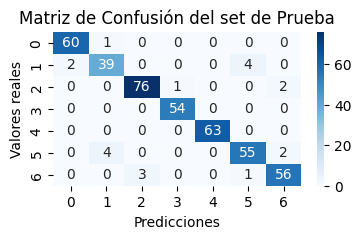

Classification Report del set de Prueba:
                     precision    recall  f1-score   support

Insufficient_Weight       0.97      0.98      0.98        61
      Normal_Weight       0.89      0.87      0.88        45
     Obesity_Type_I       0.96      0.96      0.96        79
    Obesity_Type_II       0.98      1.00      0.99        54
   Obesity_Type_III       1.00      1.00      1.00        63
 Overweight_Level_I       0.92      0.90      0.91        61
Overweight_Level_II       0.93      0.93      0.93        60

           accuracy                           0.95       423
          macro avg       0.95      0.95      0.95       423
       weighted avg       0.95      0.95      0.95       423



In [5]:
filepath = 'D:\\MNA\\MLOps\\obesity\\data\\raw\\ObesityDataSet_raw_and_data_sinthetic.csv'

model = ObesityLevelModel(filepath)
model.load_data()
model.preprocess_data()
model.create_model_pipeline()
model.train_model()
model.evaluate_model()
